In [2]:

# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import queue as Queue
import time
import sys
import scipy
#
import io
import TNCmodem as TNC
from PIL import Image
import compression
import zipfile
import imageio
#
from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
import threading

from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import newax25 as ax25

import multiprocessing

from math import gcd
import sounddevice as sd
import RPi.GPIO as GPIO
from functools import reduce
from numpy import ones,zeros, pi, cos, exp, sign

In [65]:
sd.query_devices()

  0 bcm2835 ALSA: - (hw:0,0), ALSA (0 in, 2 out)
  1 bcm2835 ALSA: IEC958/HDMI (hw:0,1), ALSA (0 in, 2 out)
  2 USB Audio Device: - (hw:1,0), ALSA (1 in, 2 out)
  3 sysdefault, ALSA (0 in, 128 out)
  4 dmix, ALSA (0 in, 2 out)
* 5 default, ALSA (1 in, 2 out)

In [66]:
builtin_idx = 0
usb_idx = 2
sd.default.samplerate=48000
sd.default.channels = 1

In [67]:
#create a queue to store packets
Qin = Queue.Queue()

def queueREC_callback(indata, outdata, frames, time, status):
    if status:
        print(status)
    outdata[:] = indata
    Qin.put_nowait( indata.copy()[:,0] )  # Global queue

In [68]:
sd.default.samplerate=48000
sd.default.channels = 1

st_rec = sd.Stream( device=(usb_idx, builtin_idx), callback=queueREC_callback)

In [69]:
fs = 48000
modem = TNC.TNCaprs(fs = fs ,Abuffer = 512,Nchunks = 1)

#start recording
st_rec.start()
#fname = ""

def decode_packets():
    print("decoding packets")
    starttime = time.time()
    npack = 0
    state = 0
    while(1):
        tmp = Qin.get() 

        packets  = modem.processBuffer(tmp)
        for pkt in packets: 
            ax = modem.decodeAX25(pkt)
            npack = npack + 1



            infostr = "%(n) 2i) | DEST: %(dest)s | SRC: %(src)s | DIGI: %(digi)s | %(info)s |" % {
                            'n': npack,
                            'dest': ax.destination,
                            'src': ax.source,
                            'digi': ax.digipeaters,
                            'info': ax.info.strip()
                        }
            print(infostr)

            if state == 0 and ax.destination[:5]=="BEGIN":
                f1 = open("rec_"+ax.info.decode(),"wb")
                #fname = "rec_"+ax.info.decode()
                #f1 = io.BufferedWriter(Bytes.IO())
                state = 1
            elif state == 1 and ax.destination[:3] == "END": 
                state = 2  
                break
            elif state == 1:
                f1.write(ax.info)
                print("write")
        if state == 2 :
            break

    print(time.time() - starttime)
    
    f1.close()

decode_packets()
st_rec.stop()
st_rec.close()

decoding packets
 1) | DEST: BEGIN 0 | SRC: KM6QHB | DIGI:       0 | b'img.zip' |
 2) | DEST: 0     0 | SRC: KM6QHB | DIGI:       0 | b'PK\x03\x04\x14\x00\x00\x00\x00\x00\t\x93\xa4L=\xfaoV>\x0f\x00\x00>\x0f\x00\x00\n\x00\x00\x00imagey.txt72 112 15 0 -6 0 -2 0 2 0 4 0 -1 0 1 1 19 0 -6 1 2 0 23 4 -3 0 -2 0 -2 1 -1 0 -1 1 15 0 -6 0 -2 0 2 0 4 0 -1 0 1 1 19 0 -6 1 2 0 23 4 -3 0 -2 0 -2 1 -1 0 -1 1 19 0 4 0 6 0 -1 1 -1 2 21 0 -7 0 1 0 1 1 -4 0 20 2 5 0 3' |
write
 3) | DEST: 1     0 | SRC: KM6QHB | DIGI:       0 | b'0 1 0 2 1 -1 0 -3 0 19 0 1 0 -4 0 3 0 -1 0 -1 0 1 1 22 0 -4 0 3 0 2 1 -4 0 2 1 18 0 -2 0 3 1 5 0 1 2 19 0 -2 0 2 0 2 0 -2 0 4 0 -3 1 19 0 11 0 -9 3 2 0 4 2 2 0 5 6 2 0 1 6 1 1 4 5 2 0 5 6 2 0 1 6 1 1 -2 4 1 2 1 0 1 3 -2 7 1 3 1 0 -1 2 4 0 1 0 1 1 2 12 -2 1' |
write
 4) | DEST: 2     0 | SRC: KM6QHB | DIGI:       0 | b'-1 0 2 3 1 0 1 1 14 684 -7 0 3 0 1 0 -2 0 -2 0 1 0 19 1 6 1 2 0 24 4 -2 0 1 0 1 1 -1 0 1 1 14 0 -7 0 3 0 1 0 -2 0 -2 0 1 0 19 1 6 1 2 0 24 4 -2 0 1 0 1 1 -1 0 1 1 

 26) | DEST: END   0 | SRC: KM6QHB | DIGI:       0 | b'This is the end of transmission' |
62.81010866165161


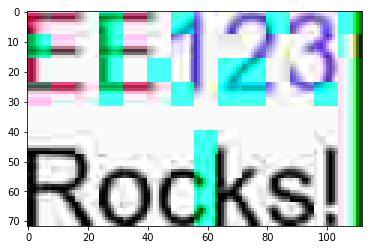

In [70]:
# f1.seek(0)
#recv_img = Image.open(f1)
with zipfile.ZipFile("rec_img.zip", 'r') as zip_recv:
#zip_recv = zipfile.ZipFile("rec_img.zip", 'r')
    zip_recv.extractall()
#inverse DCT function here
#new_img = ###FUNCTION(recv_img)
#y = open("imagey.txt", 'r')
with open("imagey.txt", 'r') as y_file:
    y = y_file.read()
#cr = open("imagecr.txt", 'r')
with open("imagecr.txt", 'r') as cr_file:
    cr = cr_file.read()
#cb = open("imagecb.txt", 'r')
with open("imagecb.txt", 'r') as cb_file:
    cb = cb_file.read()
dec_image=compression.decompress(y,cr,cb)
plt.imshow(dec_image)

In [74]:
img = Image.fromarray(dec_image)
img.save("rec_EE_test.tiff")
rgbImage = scipy.misc.imread("EE_test.tiff")
#rgbImage = np.array(rgbImage)
compression.EE123_psnr(rgbImage,dec_image)

OSError: cannot identify image file 'EE_test.tiff'

In [48]:
print (np.shape(rgbImage))
print (np.shape(dec_image))
test=np.resize((dec_image),(346,768,3))

(346, 768, 3)
(352, 768, 3)


In [50]:
compression.EE123_psnr(rgbImage,test)

6.4395253280767841

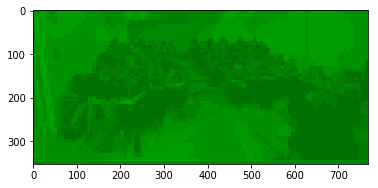

In [3]:
mid_img = Image.open("rec_mid_test.tiff")
plt.imshow(mid_img)

In [6]:
print (np.shape(mid_img))
print (np.shape(orig_img))
mid_img = np.resize((mid_img),(346,768,3))

(352, 768, 3)
(346, 768, 3)


In [8]:
orig_img = scipy.misc.imread("mid_test.tiff")
compression.EE123_psnr(mid_img, orig_img)

6.4395253280767841